In [294]:
import pandas as pd
import numpy as np
from tqdm import tqdm
tqdm.pandas(desc="progress-bar")

# Feature
import gensim
from gensim.models.word2vec import Word2Vec
from gensim.models.doc2vec import TaggedDocument
import multiprocessing
from sklearn import utils
from gensim.models import KeyedVectors

# Modeling
from keras.utils import to_categorical
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten, Conv1D, GlobalMaxPooling1D, Input, Dense, concatenate, Activation
from tensorflow.keras.layers import Embedding
from keras.regularizers import l2
from keras.callbacks import ModelCheckpoint
from keras.models import load_model
from keras.callbacks import EarlyStopping

# Evaluation
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import seaborn as sns

In [295]:
# Membaca data
train_data = pd.read_csv('../../Data/5. Split/train_data.csv')
test_data = pd.read_csv('../../Data/5. Split/test_data.csv')

In [296]:
# Memisahkan fitur dan label untuk setiap bagian dataset
x_train = train_data.text_manual_replaced
y_train = train_data.label

x_test = test_data.text_manual_replaced
y_test = test_data.label

TaggedDocument

In [297]:
def labelize_comments_ug(comments, label):
    """
    Fungsi ini mengonversi setiap komentar YouTube menjadi objek TaggedDocument 
    yang terdiri dari kata-kata dalam komentar dan label/tag yang terkait dengan komentar tersebut.
    """
    result = []
    prefix = label
    for i, c in zip(comments.index, comments):
        result.append(TaggedDocument(c.split(), [prefix + '_%s' % i]))
    return result


In [298]:
# Menggabungkan semua data komentar (latih, validasi, dan uji)
all_comments = pd.concat([x_train, x_test])

# Mengonversi semua komentar YouTube menjadi objek TaggedDocument
all_comments_w2v = labelize_comments_ug(all_comments, 'all')

Word2Vec

Word2Vec dengan arsitektur Continuous Bag of Words (CBOW)

In [299]:
# Jumlah core CPU yang tersedia
cores = multiprocessing.cpu_count()

# Membuat model Word2Vec dengan arsitektur CBOW
model_ug_cbow = Word2Vec(
    sg=0,  # Menggunakan CBOW (sg=0)
    vector_size=100,  # Ukuran vektor fitur
    negative=5,  # Jumlah negative sampling
    window=2,  # Jarak maksimum antara kata target dan kata-kata yang mengelilinginya
    min_count=1,  # Minimum jumlah kemunculan kata untuk dimasukkan ke dalam model
    workers=cores,  # Jumlah worker yang akan digunakan
    alpha=0.065,  # Learning rate awal
    min_alpha=0.065,  # Learning rate minimum
    hs=1,  # Menggunakan hierarchical softmax
)

# Membangun kosakata dari semua komentar yang telah dikonversi menjadi TaggedDocument
model_ug_cbow.build_vocab([x.words for x in tqdm(all_comments_w2v)])

100%|██████████| 4776/4776 [00:00<00:00, 1594269.47it/s]


In [300]:
%%time
# Melatih model Word2Vec dengan arsitektur CBOW sebanyak 10 epoch 
for epoch in range(30):
    # Mengacak urutan data untuk setiap epoch
    shuffled_data = utils.shuffle([x.words for x in tqdm(all_comments_w2v)])
    
    # Melatih model dengan data yang telah diacak
    model_ug_cbow.train(shuffled_data, total_examples=len(all_comments_w2v), epochs=1)
    
    # Mengurangi learning rate sebesar 0.002 setiap epoch
    model_ug_cbow.alpha -= 0.002
    
    # Menyesuaikan learning rate minimum agar sama dengan learning rate saat ini
    model_ug_cbow.min_alpha = model_ug_cbow.alpha


100%|██████████| 4776/4776 [00:00<00:00, 2353936.06it/s]

CPU times: total: 8.62 s
Wall time: 2.58 s


In [301]:
# Membuat model Word2Vec dengan arsitektur Skip-gram
model_ug_sg = Word2Vec(
    sg=1,  # Menggunakan Skip-gram (sg=1)
    vector_size=100,  # Ukuran vektor fitur
    negative=5,  # Jumlah negative sampling
    window=2,  # Jarak maksimum antara kata target dan kata-kata yang mengelilinginya
    min_count=1,  # Minimum jumlah kemunculan kata untuk dimasukkan ke dalam model
    workers=cores,  # Jumlah worker yang akan digunakan
    alpha=0.065,  # Learning rate awal
    min_alpha=0.065,  # Learning rate minimum
    hs=1,  # Menggunakan hierarchical softmax
)

# Membangun kosakata dari semua komentar yang telah dikonversi menjadi TaggedDocument
model_ug_sg.build_vocab([x.words for x in tqdm(all_comments_w2v)])


100%|██████████| 4776/4776 [00:00<00:00, 1596047.80it/s]


In [302]:
%%time
# Melatih model Word2Vec dengan arsitektur Skip-gram sebanyak 10 epoch
for epoch in range(30):
    # Mengacak urutan data untuk setiap epoch
    shuffled_data = utils.shuffle([x.words for x in tqdm(all_comments_w2v)])
    
    # Melatih model dengan data yang telah diacak
    model_ug_sg.train(shuffled_data, total_examples=len(all_comments_w2v), epochs=1)
    
    # Mengurangi learning rate sebesar 0.002 setiap epoch
    model_ug_sg.alpha -= 0.002
    
    # Menyesuaikan learning rate minimum agar sama dengan learning rate saat ini
    model_ug_sg.min_alpha = model_ug_sg.alpha


100%|██████████| 4776/4776 [00:00<00:00, 2394453.25it/s]


CPU times: total: 19.3 s
Wall time: 3.78 s


In [303]:
# Menyimpan model Word2Vec CBOW yang telah dilatih
model_ug_cbow.save('./../../Model/w2v_model_ug_cbow.word2vec')

# Menyimpan model Word2Vec Skip-gram yang telah dilatih
model_ug_sg.save('./../../Model/w2v_model_ug_sg.word2vec')

In [304]:
# Memuat model Word2Vec CBOW yang telah disimpan
model_ug_cbow = KeyedVectors.load('./../../Model/w2v_model_ug_cbow.word2vec')

# Memuat model Word2Vec Skip-gram yang telah disimpan
model_ug_sg = KeyedVectors.load('./../../Model/w2v_model_ug_sg.word2vec')

In [305]:
# Menghitung jumlah kata unik dalam model Word2Vec CBOW
unique_words_count = len(model_ug_cbow.wv.index_to_key)

# Menampilkan jumlah kata unik
print(unique_words_count)

7350


In [306]:
embeddings_index = {}

# Menggabungkan kedua embeddings dari model CBOW dan Skip-gram untuk setiap kata unik
for w in model_ug_cbow.wv.index_to_key:
    embeddings_index[w] = np.append(model_ug_cbow.wv[w], model_ug_sg.wv[w])

# Menampilkan jumlah vektor kata yang ditemukan
print('Found %s word vectors.' % len(embeddings_index))

Found 7350 word vectors.


In [307]:
# Membuat tokenizer dengan jumlah kata maksimum 1500
tokenizer = Tokenizer(num_words=1500)  # num_words adalah jumlah kosakata yang ingin digunakan

# Melatih tokenizer pada teks dari data latih
tokenizer.fit_on_texts(x_train)

# Mengonversi teks menjadi urutan bilangan bulat yang merepresentasikan indeks kata
sequences = tokenizer.texts_to_sequences(x_train)

In [308]:
# Menghitung jumlah kata unik dalam tokenizer
unique_token_count = len(tokenizer.word_index)

# Menampilkan jumlah kata unik
print(unique_token_count)

6053


In [309]:
# Menampilkan 5 teks pertama dari data latih (x_train)
for x in x_train[:5]:
    print(x)

bagus pak dokter
kok sekarang baru tahu lalu apa tugas bpom
betul dokter minum kemas lebih bahaya
jajan minum banyak jual warung warung perlu teliti kandung zat apa saj yang masuk hewan tidak suka lalau kasih anak anak konsumsi dong komisi lindung anak bantu masyarakat selidik jajan anak bangsa
suara dokter richard itu khas banget biarpun wajah enggak lihat suara kenal orang sudah jadi selebriti repot privasi jadi kurang semangat sukses terus iya dok buat edukasi masyarakat


In [310]:
# Menampilkan urutan indeks kata dari teks pertama dalam data latih (sequences)
print(sequences[:1])

[[191, 136, 7]]


In [311]:
length = []

# Menghitung jumlah kata dalam setiap teks dari data latih (x_train) dan menyimpannya dalam daftar length
for x in x_train:
    length.append(len(x.split()))

# length berisi panjang (jumlah kata) dari setiap teks dalam data latih

In [312]:
# Menghitung jumlah kata maksimum dalam satu kalimat dari data latih (x_train)
max_word_count = max(length)

# Menampilkan jumlah kata maksimum
print("Maximum number of words in a sentence:", max_word_count)

Maximum number of words in a sentence: 399


In [313]:
# Menetapkan panjang maksimum urutan (max_len) untuk padding
max_len = 400

# max_len digunakan untuk membatasi panjang urutan maksimum saat melakukan padding

In [314]:
# Melakukan padding pada urutan data latih (x_train) agar memiliki panjang yang sama (max_len)
x_train_seq = pad_sequences(sequences, maxlen=max_len)

# Menampilkan bentuk tensor data latih yang telah dipad (x_train_seq)
print('Shape of padded data tensor:', x_train_seq.shape)

Shape of padded data tensor: (3582, 400)


In [315]:
# Menampilkan 5 sampel pertama dari data latih yang telah dipad (x_train_seq)
print(x_train_seq[:5])


[[  0   0   0 ... 191 136   7]
 [  0   0   0 ...  10 633  16]
 [  0   0   0 ... 187  36  98]
 [  0   0   0 ... 156   3 555]
 [  0   0   0 ...  29 120  92]]


In [316]:
# Mengonversi teks dalam data test (x_tes) menjadi urutan angka menggunakan tokenizer yang sama
sequences_val = tokenizer.texts_to_sequences(x_test)

# Melakukan padding pada urutan data validasi agar memiliki panjang yang sama (max_len)
x_test_seq = pad_sequences(sequences_val, maxlen=max_len)

# Komentar: Sekarang, x_test_seq berisi data validasi yang telah dipad dan siap digunakan

In [317]:
# Menetapkan jumlah kata yang akan digunakan dalam matriks embedding
num_words = len(tokenizer.word_index) + 1

# Membuat matriks embedding kosong dengan bentuk (num_words, 200)
embedding_matrix = np.zeros((num_words, 200))

# Mengisi matriks embedding dengan vektor embedding yang sesuai dari embeddings_index
for word, i in tokenizer.word_index.items():
    if i >= num_words:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

# Komentar: embedding_matrix sekarang berisi vektor embedding untuk seluruh kata unik dalam tokenizer.word_index

In [318]:
# Memeriksa kesetaraan antara vektor embedding ke-29 dalam matriks embedding dan vektor embedding kata 'baik' dalam embeddings_index
equal_vectors = np.array_equal(embedding_matrix[29], embeddings_index.get('baik'))

# Cetak hasil kesetaraan vektor
print("Apakah vektor embedding ke-29 sama dengan vektor embedding kata 'baik'?", equal_vectors)

Apakah vektor embedding ke-29 sama dengan vektor embedding kata 'baik'? False


In [319]:
# Cari indeks kata 'baik' dalam tokenizer.word_index
baik_index = tokenizer.word_index.get('baik')

# Memeriksa kesetaraan antara vektor embedding kata 'baik' dalam matriks embedding dan vektor embedding kata 'baik' dalam embeddings_index
equal_vectors = np.array_equal(embedding_matrix[baik_index], embeddings_index.get('baik'))

# Cetak hasil kesetaraan vektor
print("Apakah vektor embedding untuk kata 'baik' di posisi yang benar dalam embedding_matrix sama dengan vektor embedding kata 'baik'?", equal_vectors)

Apakah vektor embedding untuk kata 'baik' di posisi yang benar dalam embedding_matrix sama dengan vektor embedding kata 'baik'? True


In [320]:
# Ubah label menjadi one-hot encoding
y_train_cat = to_categorical(y_train + 1, num_classes=3)
y_test_cat = to_categorical(y_test + 1, num_classes=3)

Pemodelan CNN

In [321]:
# Membuat model Sequential
model_cnn_01 = Sequential()

# Menambahkan layer Embedding dengan matriks bobot yang sudah ada
e = Embedding(num_words, 200, weights=[embedding_matrix], input_length=max_len, trainable=False)
model_cnn_01.add(e)

# Menambahkan layer Conv1D
model_cnn_01.add(Conv1D(filters=100, kernel_size=2, padding='valid', activation='relu', strides=1))

# Menambahkan layer GlobalMaxPooling1D
model_cnn_01.add(GlobalMaxPooling1D())

# Menambahkan layer Dense dengan aktivasi ReLU
model_cnn_01.add(Dense(256, activation='relu'))

# Menambahkan layer Dense dengan aktivasi softmax untuk klasifikasi multi-kelas
model_cnn_01.add(Dense(3, activation='softmax'))

# Mengkompilasi model dengan fungsi loss 'categorical_crossentropy', optimizer 'adam', dan metrik evaluasi 'accuracy'
model_cnn_01.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Menambahkan EarlyStopping untuk menghentikan pelatihan jika akurasi validasi tidak meningkat
early_stopping = EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True)

model_cnn_01.summary()

Model: "sequential_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_27 (Embedding)    (None, 400, 200)          1210800   
                                                                 
 conv1d_35 (Conv1D)          (None, 399, 100)          40100     
                                                                 
 global_max_pooling1d_35 (Gl  (None, 100)              0         
 obalMaxPooling1D)                                               
                                                                 
 dense_54 (Dense)            (None, 256)               25856     
                                                                 
 dense_55 (Dense)            (None, 3)                 771       
                                                                 
Total params: 1,277,527
Trainable params: 66,727
Non-trainable params: 1,210,800
______________________________________

In [322]:
# Melatih model dengan data latih dan validasi (gunakan y_train_cat dan y_test_cat untuk label one-hot encoded)
model_cnn_01.fit(x_train_seq, y_train_cat, validation_data=(x_test_seq, y_test_cat), epochs=5, batch_size=32, callbacks=[early_stopping], verbose=2)

Epoch 1/5
112/112 - 4s - loss: 0.9687 - accuracy: 0.5391 - val_loss: 0.8612 - val_accuracy: 0.6256 - 4s/epoch - 35ms/step
Epoch 2/5
112/112 - 3s - loss: 0.7316 - accuracy: 0.6887 - val_loss: 0.9019 - val_accuracy: 0.6323 - 3s/epoch - 29ms/step
Epoch 3/5
112/112 - 3s - loss: 0.5561 - accuracy: 0.7859 - val_loss: 0.9510 - val_accuracy: 0.6139 - 3s/epoch - 28ms/step
Epoch 4/5
112/112 - 3s - loss: 0.3669 - accuracy: 0.8735 - val_loss: 1.0200 - val_accuracy: 0.6399 - 3s/epoch - 26ms/step
Epoch 5/5
112/112 - 5s - loss: 0.2216 - accuracy: 0.9316 - val_loss: 1.1825 - val_accuracy: 0.6441 - 5s/epoch - 40ms/step


In [323]:
# Membuat model Sequential
model_cnn_02 = Sequential()

# Menambahkan layer Embedding
e = Embedding(num_words, 200, input_length=max_len)
model_cnn_02.add(e)

# Menambahkan layer Conv1D
model_cnn_02.add(Conv1D(filters=100, kernel_size=2, padding='valid', activation='relu', strides=1))

# Menambahkan layer GlobalMaxPooling1D
model_cnn_02.add(GlobalMaxPooling1D())

# Menambahkan layer Dense dengan aktivasi ReLU
model_cnn_02.add(Dense(256, activation='relu'))

# Menambahkan layer Dense output dengan aktivasi softmax untuk klasifikasi multi-kelas
model_cnn_02.add(Dense(3, activation='softmax'))

# Mengkompilasi model dengan fungsi loss 'categorical_crossentropy', optimizer 'adam', dan metrik evaluasi 'accuracy'
model_cnn_02.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model_cnn_02.summary()

Model: "sequential_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_28 (Embedding)    (None, 400, 200)          1210800   
                                                                 
 conv1d_36 (Conv1D)          (None, 399, 100)          40100     
                                                                 
 global_max_pooling1d_36 (Gl  (None, 100)              0         
 obalMaxPooling1D)                                               
                                                                 
 dense_56 (Dense)            (None, 256)               25856     
                                                                 
 dense_57 (Dense)            (None, 3)                 771       
                                                                 
Total params: 1,277,527
Trainable params: 1,277,527
Non-trainable params: 0
___________________________________________

In [324]:
# Melatih model dengan data latih dan data validasi
model_cnn_02.fit(x_train_seq, y_train_cat, validation_data=(x_test_seq, y_test_cat), epochs=5, batch_size=32, callbacks=[early_stopping], verbose=2)

Epoch 1/5
112/112 - 13s - loss: 0.9618 - accuracy: 0.5486 - val_loss: 0.8469 - val_accuracy: 0.6332 - 13s/epoch - 118ms/step
Epoch 2/5
112/112 - 6s - loss: 0.6492 - accuracy: 0.7393 - val_loss: 0.8047 - val_accuracy: 0.6792 - 6s/epoch - 58ms/step
Epoch 3/5
112/112 - 6s - loss: 0.4207 - accuracy: 0.8487 - val_loss: 0.8978 - val_accuracy: 0.6407 - 6s/epoch - 58ms/step
Epoch 4/5
112/112 - 6s - loss: 0.2157 - accuracy: 0.9366 - val_loss: 1.0667 - val_accuracy: 0.6407 - 6s/epoch - 58ms/step
Epoch 5/5
112/112 - 7s - loss: 0.1037 - accuracy: 0.9740 - val_loss: 1.2031 - val_accuracy: 0.6357 - 7s/epoch - 60ms/step


In [325]:
# Membuat model Sequential
model_cnn_03 = Sequential()

# Menambahkan lapisan Embedding dengan ukuran embedding 200
e = Embedding(num_words, 200, input_length=max_len)
model_cnn_03.add(e)

# Menambahkan lapisan Conv1D dengan 100 filter, kernel size 2, fungsi aktivasi ReLU, regularisasi L2, dan stride 1
model_cnn_03.add(Conv1D(filters=100, kernel_size=2, padding='valid', activation='relu', strides=1, kernel_regularizer=l2(0.01)))

# Menambahkan lapisan GlobalMaxPooling1D untuk mengurangi dimensi
model_cnn_03.add(GlobalMaxPooling1D())

# Menambahkan lapisan Dense dengan 256 unit dan fungsi aktivasi ReLU, serta regularisasi L2
model_cnn_03.add(Dense(256, activation='relu', kernel_regularizer=l2(0.01)))

# Menambahkan lapisan Dropout dengan tingkat dropout 0.5 untuk mengurangi overfitting
model_cnn_03.add(Dropout(0.5))

# Menambahkan lapisan Dense output dengan 3 unit (untuk 3 kelas) dan fungsi aktivasi softmax
model_cnn_03.add(Dense(3, activation='softmax'))

# Mengkompilasi model dengan categorical_crossentropy loss, optimizer Adam, dan metrik akurasi
model_cnn_03.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model_cnn_03.summary()

Model: "sequential_25"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_29 (Embedding)    (None, 400, 200)          1210800   
                                                                 
 conv1d_37 (Conv1D)          (None, 399, 100)          40100     
                                                                 
 global_max_pooling1d_37 (Gl  (None, 100)              0         
 obalMaxPooling1D)                                               
                                                                 
 dense_58 (Dense)            (None, 256)               25856     
                                                                 
 dropout_20 (Dropout)        (None, 256)               0         
                                                                 
 dense_59 (Dense)            (None, 3)                 771       
                                                     

In [326]:
# Melatih model dengan data latih dan data validasi
model_cnn_03.fit(x_train_seq, y_train_cat, validation_data=(x_test_seq, y_test_cat), epochs=5, batch_size=32, callbacks=[early_stopping], verbose=2)

Epoch 1/5
112/112 - 13s - loss: 1.9366 - accuracy: 0.4327 - val_loss: 1.1581 - val_accuracy: 0.5109 - 13s/epoch - 117ms/step
Epoch 2/5
112/112 - 7s - loss: 0.9778 - accuracy: 0.6234 - val_loss: 0.9545 - val_accuracy: 0.6323 - 7s/epoch - 59ms/step
Epoch 3/5
112/112 - 7s - loss: 0.8162 - accuracy: 0.7063 - val_loss: 0.9456 - val_accuracy: 0.6332 - 7s/epoch - 58ms/step
Epoch 4/5
112/112 - 7s - loss: 0.7358 - accuracy: 0.7535 - val_loss: 0.9434 - val_accuracy: 0.6441 - 7s/epoch - 60ms/step
Epoch 5/5
112/112 - 6s - loss: 0.6714 - accuracy: 0.7881 - val_loss: 0.9664 - val_accuracy: 0.6357 - 6s/epoch - 58ms/step


In [327]:
# Membangun model
model_cnn_04 = Sequential()

# Menambahkan lapisan Embedding dengan matriks embedding yang dapat dilatih
e = Embedding(num_words, 200, weights=[embedding_matrix], input_length=max_len, trainable=True)
model_cnn_04.add(e)

# Menambahkan lapisan Conv1D
model_cnn_04.add(Conv1D(filters=100, kernel_size=2, padding='valid', activation='relu', strides=1))

# Menambahkan lapisan GlobalMaxPooling1D
model_cnn_04.add(GlobalMaxPooling1D())

# Menambahkan lapisan Dense pertama dengan fungsi aktivasi ReLU dan dropout
model_cnn_04.add(Dense(256, activation='relu'))
model_cnn_04.add(Dropout(0.6))  # Menambahkan dropout

# Menambahkan lapisan Dense kedua dengan fungsi aktivasi softmax untuk klasifikasi multi-kelas
model_cnn_04.add(Dense(3, activation='softmax'))

# Mengkompilasi model dengan fungsi loss 'categorical_crossentropy', optimizer 'adam', dan metrik evaluasi 'accuracy'
model_cnn_04.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model_cnn_04.summary()

Model: "sequential_26"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_30 (Embedding)    (None, 400, 200)          1210800   
                                                                 
 conv1d_38 (Conv1D)          (None, 399, 100)          40100     
                                                                 
 global_max_pooling1d_38 (Gl  (None, 100)              0         
 obalMaxPooling1D)                                               
                                                                 
 dense_60 (Dense)            (None, 256)               25856     
                                                                 
 dropout_21 (Dropout)        (None, 256)               0         
                                                                 
 dense_61 (Dense)            (None, 3)                 771       
                                                     

In [328]:
# Melatih model menggunakan data latihan dan validasi
model_cnn_04.fit(x_train_seq, y_train_cat, validation_data=(x_test_seq, y_test_cat), epochs=5, batch_size=32, callbacks=[early_stopping], verbose=2)

Epoch 1/5
112/112 - 12s - loss: 1.0609 - accuracy: 0.4863 - val_loss: 0.9113 - val_accuracy: 0.5896 - 12s/epoch - 108ms/step
Epoch 2/5
112/112 - 6s - loss: 0.8191 - accuracy: 0.6466 - val_loss: 0.8399 - val_accuracy: 0.6399 - 6s/epoch - 52ms/step
Epoch 3/5
112/112 - 7s - loss: 0.6698 - accuracy: 0.7264 - val_loss: 0.8180 - val_accuracy: 0.6591 - 7s/epoch - 64ms/step
Epoch 4/5
112/112 - 7s - loss: 0.5190 - accuracy: 0.7979 - val_loss: 0.8436 - val_accuracy: 0.6549 - 7s/epoch - 60ms/step
Epoch 5/5
112/112 - 7s - loss: 0.3829 - accuracy: 0.8638 - val_loss: 0.9412 - val_accuracy: 0.6533 - 7s/epoch - 60ms/step


In [329]:
model_cnn_05 = Sequential()

# Menambahkan lapisan Embedding dengan matriks embedding yang dapat dilatih
e = Embedding(num_words, 200, weights=[embedding_matrix], input_length=max_len, trainable=True)
model_cnn_05.add(e)

# Menambahkan lapisan Conv1D dengan regularisasi L2 dan Dropout
model_cnn_05.add(Conv1D(filters=100, kernel_size=2, padding='valid', activation='relu', strides=1, kernel_regularizer=l2(0.01)))
model_cnn_05.add(Dropout(0.5))

# Menambahkan lapisan GlobalMaxPooling1D
model_cnn_05.add(GlobalMaxPooling1D())

# Menambahkan lapisan Dense pertama dengan fungsi aktivasi ReLU dan regularisasi L2
model_cnn_05.add(Dense(256, activation='relu', kernel_regularizer=l2(0.01)))
model_cnn_05.add(Dropout(0.5))

# Menambahkan lapisan Dense kedua dengan fungsi aktivasi softmax untuk klasifikasi multi-kelas
model_cnn_05.add(Dense(3, activation='softmax'))

model_cnn_05.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model_cnn_05.summary()


Model: "sequential_27"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_31 (Embedding)    (None, 400, 200)          1210800   
                                                                 
 conv1d_39 (Conv1D)          (None, 399, 100)          40100     
                                                                 
 dropout_22 (Dropout)        (None, 399, 100)          0         
                                                                 
 global_max_pooling1d_39 (Gl  (None, 100)              0         
 obalMaxPooling1D)                                               
                                                                 
 dense_62 (Dense)            (None, 256)               25856     
                                                                 
 dropout_23 (Dropout)        (None, 256)               0         
                                                     

In [330]:
# Melatih model menggunakan data latihan dan validasi
model_cnn_05.fit(x_train_seq, y_train_cat, validation_data=(x_test_seq, y_test_cat), epochs=5, batch_size=32, callbacks=[early_stopping], verbose=2)

Epoch 1/5
112/112 - 15s - loss: 3.4076 - accuracy: 0.4738 - val_loss: 2.8395 - val_accuracy: 0.5369 - 15s/epoch - 134ms/step
Epoch 2/5
112/112 - 8s - loss: 2.4392 - accuracy: 0.5949 - val_loss: 2.1632 - val_accuracy: 0.6198 - 8s/epoch - 73ms/step
Epoch 3/5
112/112 - 9s - loss: 1.8746 - accuracy: 0.6555 - val_loss: 1.7548 - val_accuracy: 0.6273 - 9s/epoch - 78ms/step
Epoch 4/5
112/112 - 8s - loss: 1.5114 - accuracy: 0.6843 - val_loss: 1.4883 - val_accuracy: 0.6449 - 8s/epoch - 75ms/step
Epoch 5/5
112/112 - 8s - loss: 1.2613 - accuracy: 0.7138 - val_loss: 1.3011 - val_accuracy: 0.6516 - 8s/epoch - 73ms/step


In [331]:
# Membuat model CNN dengan multiple filter sizes (bigram, trigram, dan fourgram) untuk klasifikasi teks dengan 3 kelas
comment_input = Input(shape=(max_len,), dtype='int32')

# Menambahkan lapisan Embedding dengan matriks embedding yang telah dilatih (pre-trained) dan trainable
comment_encoder = Embedding(num_words, 200, weights=[embedding_matrix], input_length=max_len, trainable=True)(comment_input)

# Membuat cabang bigram dengan Conv1D, kernel size 2, dan regularisasi L2
bigram_branch = Conv1D(filters=100, kernel_size=2, padding='valid', activation='relu', strides=1, kernel_regularizer=l2(0.01))(comment_encoder)
bigram_branch = GlobalMaxPooling1D()(bigram_branch)

# Membuat cabang trigram dengan Conv1D, kernel size 3, dan regularisasi L2
trigram_branch = Conv1D(filters=100, kernel_size=3, padding='valid', activation='relu', strides=1, kernel_regularizer=l2(0.01))(comment_encoder)
trigram_branch = GlobalMaxPooling1D()(trigram_branch)

# Membuat cabang fourgram dengan Conv1D, kernel size 4, dan regularisasi L2
fourgram_branch = Conv1D(filters=100, kernel_size=4, padding='valid', activation='relu', strides=1, kernel_regularizer=l2(0.01))(comment_encoder)
fourgram_branch = GlobalMaxPooling1D()(fourgram_branch)

# Menggabungkan output dari ketiga cabang
merged = concatenate([bigram_branch, trigram_branch, fourgram_branch], axis=1)

# Menambahkan lapisan Dense dengan 256 unit, fungsi aktivasi ReLU, dan regularisasi L2
merged = Dense(256, activation='relu', kernel_regularizer=l2(0.01))(merged)

# Menambahkan lapisan Dropout dengan tingkat dropout 0.2 untuk mengurangi overfitting
merged = Dropout(0.2)(merged)

# Menambahkan lapisan Dense output dengan 3 unit (untuk 3 kelas)
merged = Dense(3)(merged)

# Menambahkan lapisan aktivasi dengan fungsi aktivasi sigmoid
output = Activation('sigmoid')(merged)

# Membuat model dengan input dan output yang telah ditentukan
model_cnn_06 = Model(inputs=[comment_input], outputs=[output])

# Mengkompilasi model dengan categorical_crossentropy loss, optimizer Adam, dan metrik akurasi
model_cnn_06.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

# Menampilkan ringkasan model
model_cnn_06.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 400)]        0           []                               
                                                                                                  
 embedding_32 (Embedding)       (None, 400, 200)     1210800     ['input_5[0][0]']                
                                                                                                  
 conv1d_40 (Conv1D)             (None, 399, 100)     40100       ['embedding_32[0][0]']           
                                                                                                  
 conv1d_41 (Conv1D)             (None, 398, 100)     60100       ['embedding_32[0][0]']           
                                                                                            

In [332]:
# Melatih model menggunakan data latihan dan validasi
model_cnn_06.fit(x_train_seq, y_train_cat, validation_data=(x_test_seq, y_test_cat), epochs=5, batch_size=32, callbacks=[early_stopping], verbose=2)

Epoch 1/5
112/112 - 29s - loss: 5.5555 - accuracy: 0.5327 - val_loss: 3.6796 - val_accuracy: 0.5980 - 29s/epoch - 258ms/step
Epoch 2/5
112/112 - 19s - loss: 2.6571 - accuracy: 0.7088 - val_loss: 2.1915 - val_accuracy: 0.6558 - 19s/epoch - 168ms/step
Epoch 3/5
112/112 - 19s - loss: 1.6465 - accuracy: 0.7747 - val_loss: 1.6997 - val_accuracy: 0.6340 - 19s/epoch - 171ms/step
Epoch 4/5
112/112 - 19s - loss: 1.1732 - accuracy: 0.8364 - val_loss: 1.4964 - val_accuracy: 0.6558 - 19s/epoch - 167ms/step
Epoch 5/5
112/112 - 19s - loss: 0.9084 - accuracy: 0.8872 - val_loss: 1.4190 - val_accuracy: 0.6516 - 19s/epoch - 173ms/step


Evaluasi Pemodelan CNN

In [333]:
model_1_eval = model_cnn_01.evaluate(x_test_seq, y_test_cat, verbose=0)
print("Akurasi validasi model eksperimen 1: {:.2f}%".format(model_1_eval[1] * 100))

model_2_eval = model_cnn_02.evaluate(x_test_seq, y_test_cat, verbose=0)
print("Akurasi validasi model eksperimen 2: {:.2f}%".format(model_2_eval[1] * 100))

model_3_eval = model_cnn_03.evaluate(x_test_seq, y_test_cat, verbose=0)
print("Akurasi validasi model eksperimen 3: {:.2f}%".format(model_3_eval[1] * 100))

model_4_eval = model_cnn_04.evaluate(x_test_seq, y_test_cat, verbose=0)
print("Akurasi validasi model eksperimen 4: {:.2f}%".format(model_4_eval[1] * 100))

model_5_eval = model_cnn_05.evaluate(x_test_seq, y_test_cat, verbose=0)
print("Akurasi validasi model eksperimen 5: {:.2f}%".format(model_5_eval[1] * 100))

model_6_eval = model_cnn_06.evaluate(x_test_seq, y_test_cat, verbose=0)
print("Akurasi validasi model eksperimen 6: {:.2f}%".format(model_6_eval[1] * 100))

Akurasi validasi model eksperimen 1: 64.41%
Akurasi validasi model eksperimen 2: 67.92%
Akurasi validasi model eksperimen 3: 63.57%
Akurasi validasi model eksperimen 4: 65.33%
Akurasi validasi model eksperimen 5: 65.16%
Akurasi validasi model eksperimen 6: 65.58%


In [334]:
# Membuat dictionary untuk menyimpan model dan akurasi validasi
models_eval = {
    "model_1": model_1_eval[1],
    "model_2": model_2_eval[1],
    "model_3": model_3_eval[1],
    "model_4": model_4_eval[1],
    "model_5": model_5_eval[1],
    "model_6": model_6_eval[1],
}

# Mencari model dengan akurasi validasi tertinggi
best_model_key = max(models_eval, key=models_eval.get)
best_model_accuracy = models_eval[best_model_key] * 100

# Menyimpan model dengan akurasi validasi tertinggi ke variabel baru
if best_model_key == "model_1":
    best_model = model_cnn_01
elif best_model_key == "model_2":
    best_model = model_cnn_02
elif best_model_key == "model_3":
    best_model = model_cnn_03
elif best_model_key == "model_4":
    best_model = model_cnn_04
elif best_model_key == "model_5":
    best_model = model_cnn_05
else:
    best_model = model_cnn_06

print("Model terbaik adalah {}, dengan akurasi validasi {:.2f}%".format(best_model_key, best_model_accuracy))

Model terbaik adalah model_2, dengan akurasi validasi 67.92%


In [335]:
# Menilai model CNN yang telah dilatih menggunakan data test (x_test_seq dan y_test_cat)
CNN_model_evaluation = best_model.evaluate(x=x_test_seq, y=y_test_cat)

# Memprediksi label kelas menggunakan model CNN yang telah dilatih pada data test (x_test_seq)
yhat_cnn = best_model.predict(x_test_seq)

38/38 [==============================] - 1s 16ms/step


In [336]:
# Mengkonversi prediksi probabilitas ke label kelas untuk kedua model
y_pred_cnn = np.argmax(yhat_cnn, axis=1) - 1

# Menghitung true label dari one-hot encoding
y_true = np.argmax(y_test_cat, axis=1) - 1

In [337]:
# Menampilkan classification report untuk kedua model
print("Classification Report (CNN Model):")
print(classification_report(y_true, y_pred_cnn))

Classification Report (CNN Model):
              precision    recall  f1-score   support

          -1       0.65      0.75      0.70       395
           0       0.67      0.77      0.72       448
           1       0.74      0.48      0.58       351

    accuracy                           0.68      1194
   macro avg       0.69      0.67      0.67      1194
weighted avg       0.69      0.68      0.67      1194



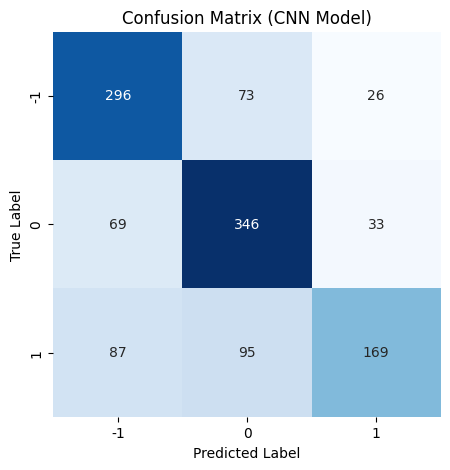

In [338]:
# Menghitung confusion matrix untuk kedua model
cm_cnn = confusion_matrix(y_true, y_pred_cnn)

# Fungsi untuk visualisasi confusion matrix
def plot_cm(cm, title):
    plt.figure(figsize=(5, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
    plt.title(title)
    plt.xticks([0.5, 1.5, 2.5], ['-1', '0', '1'])
    plt.yticks([0.5, 1.5, 2.5], ['-1', '0', '1'])
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

# Menampilkan visualisasi confusion matrix untuk kedua model
plot_cm(cm_cnn, "Confusion Matrix (CNN Model)")

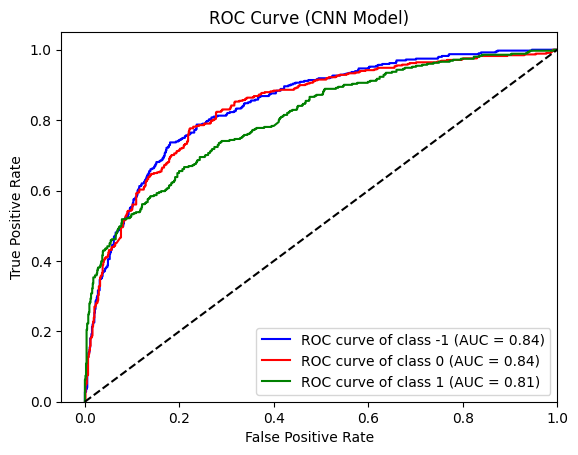

In [339]:
# Fungsi untuk menggambarkan ROC curve
def plot_roc_curve(y_true, y_score, n_classes, title):
    # Binarize the true labels
    y_true_bin = label_binarize(y_true, classes=[-1, 0, 1])

    # Menghitung ROC curve dan AUC untuk setiap kelas
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Menggambarkan ROC curve
    plt.figure()
    colors = ['blue', 'red', 'green']
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color,
                 label='ROC curve of class {0} (AUC = {1:0.2f})'
                 ''.format(i-1, roc_auc[i]))
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([-0.05, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc="lower right")
    plt.show()

# Menggambarkan ROC curve untuk kedua model
plot_roc_curve(y_true, yhat_cnn, n_classes=3, title='ROC Curve (CNN Model)')

Output

In [340]:
# Panggil dataset
full_data = pd.read_csv('../../Data/4. EDA/clean-eda.csv')

# Prediksi pada keseluruhan data
sequences_full = tokenizer.texts_to_sequences(full_data['text_manual_replaced'])
x_full_seq = pad_sequences(sequences_full, maxlen=max_len)
yhat_full_cnn= best_model.predict(x_full_seq)

# Konversi prediksi ke label kelas
yhat_full_cnn_classes = np.argmax(yhat_full_cnn, axis=1) - 1

# Tambahkan kolom baru ke DataFrame
full_data['predicted_sentiment'] = yhat_full_cnn_classes

full_data.head()

150/150 [==============================] - 2s 14ms/step


,video_id,comment_text,text_cleaned,text_removal,text_normalized,text_manual_replaced,text_tokenize,label,predicted_sentiment
0,video1,Baiknya bagaimana menurut kalian?,baiknya bagaimana menurut kalian,baik bagaimana turut kalian,baik bagaimana turut kalian,baik bagaimana turut kalian,"['baik', 'bagaimana', 'turut', 'kalian']",0,0
1,video1,Betul dok betul dok,betul dok betul dok,betul dok betul dok,betul dok betul dok,betul dok betul dok,"['betul', 'dok', 'betul', 'dok']",0,0
2,video1,Betul dok mungkin efek sa di,betul dok mungkin efek sa di,betul dok mungkin efek sa,betul dok mungkin efek sa,betul dok mungkin efek sa,"['betul', 'dok', 'mungkin', 'efek', 'sa']",0,0
3,video1,"Bpom aneh, tidak kerja. Kenapa ko seperti itu.",bpom aneh tidak kerja kenapa ko seperti itu,bpom aneh kerja ko itu,bpom aneh kerja kok itu,bpom aneh kerja kok itu,"['bpom', 'aneh', 'kerja', 'kok', 'itu']",-1,-1
4,video1,Benar banget anak sy aj hrs sirup minum obatny...,benar banget anak sy aj hrs sirup minum obatny...,benar banget anak sy aj hrs sirup minum obat d...,benar banget anak saya saja harus sirup minum ...,benar banget anak aku saja harus sirup minum o...,"['benar', 'banget', 'anak', 'aku', 'saja', 'ha...",0,0


In [341]:
#full_data.to_csv("./../../Data/6. Prediksi/submission-CNN.csv", index=False)